# **Installations**

In [0]:
!pip install kaggle
!pip install pretrainedmodels

In [0]:
from google.colab import files
files.upload()

Import RAdam

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib1.py','wb').write(src)
import mylib1

Saving gitradam.py to gitradam (2).py


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d ofriharel/224-224-cervical-cancer-screening

224-224-cervical-cancer-screening.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from zipfile import ZipFile
file_name = '224-224-cervical-cancer-screening.zip'
with ZipFile(file_name, 'r') as zipx:
    zipx.extractall()
    print('Done')

Done


# **Imports / Consts**

In [0]:
import numpy as np
import glob
import cv2
import gc
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pretrainedmodels
import os, ssl
import csv
import pandas as pd
import io

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from enum import Enum
from torch.optim.lr_scheduler import CosineAnnealingLR
from functools import cmp_to_key

# CONSTS
BATCH_SIZE = 8
NUM_CLASSES = 3

# **Image wrapper class**

In [0]:
class Im(object):
    def __init__(self, path):
        self.path = path

        self.rgb_image = None
        self.bgr_image = None
        self.gray_image = None


    def read(self, return_image = False):
        self.rgb_image = plt.imread(self.path)
        if return_image:
            return self.rgb_image


    def bgr(self, return_image = False):
        self.bgr_image = np.flip(plt.imread(self.path), 2)
        if return_image:
            return self.bgr_image


    def gray(self, return_image = False):
        self.gray_image = cv2.cvtColor(plt.imread(self.path), cv2.COLOR_RGB2GRAY)
        if return_image:
            return self.gray_image


    @staticmethod
    def show(img, title='image'):
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()


    @staticmethod
    def show_all(image_list, title_list=None):
        if title_list is None:
            title_list = ['' for i in range(len(image_list))]
        plt.figure(figsize=[20, 20])
        assert len(image_list) == len(title_list), "Houston we've got a problem"
        N = len(image_list)
        for index, (img, title) in enumerate(zip(image_list, title_list)):
            plt.subplot(1, N, index+1)
            if len(img.shape) != 3:
                plt.imshow(img, cmap='gray')
                plt.axis('off')
            else:
                plt.imshow(img)
                plt.axis('off')
                plt.title(title)
        plt.show()


    @staticmethod
    def norm(img):
      max_pixel = np.max(np.abs(img))

      if max_pixel != 0:
        return img / max_pixel
      return img

# **Dataset / Dataloader Creation**

Dataset Class

In [0]:
class CancerDataset(Dataset):
    def __init__(self, paths, transform=None, size=224, train=True):
        super(CancerDataset, self).__init__()
        self.paths = paths
        self.transform = transform
        self.size = size
        self.train = train


    def __getitem__(self, idx):
        p = self.paths[idx]

        x = plt.imread(p)
        x = cv2.resize(x, (self.size, self.size), cv2.INTER_AREA)
        x = transforms.ToPILImage()(x)

        if self.transform:
            x = self.transform(x)
        
        if self.train:
            y = int(p.split("/")[-2].split("_")[-1]) - 1
            return x.cuda(), y

        if p.split("/")[-1] is 'test':
            return x.cuda(), 0

        return x.cuda(), 1 # Then --> test_stg2


    def __len__(self):
        return len(self.paths)

Test's Paths Comperator Definition

In [0]:
def comparator():
    def compare(p1, p2):
        p1 = int(p1.split('/')[-1].split(".")[0]) 
        p2 = int(p2.split('/')[-1].split(".")[0])
        if p1 < p2:
            return -1
        elif p2 < p1:
            return 1
        else:
            return 0
    return compare

In [0]:
train_root = './kaggle/train/train/'
additional1 = './kaggle/additional_Type_1_v2/Type_1'
additional2 = './kaggle/additional_Type_2_v2/Type_2'
additional3 = './kaggle/additional_Type_3_v2/Type_3'

additional_path1 = glob.glob(additional1 + '*/*.jpg')
additional_path2 = glob.glob(additional2 + '*/*.jpg')
additional_path3 = glob.glob(additional3 + '*/*.jpg')

train_pathes = glob.glob(train_root + '*/*.jpg') + additional_path1 + additional_path2 + additional_path3

In [0]:
test_root1 = './kaggle/train/train/'
test_root2 = './kaggle/test_stg2/'
test_pathes = glob.glob(test_root1 + '*/*.jpg') + glob.glob(test_root2 + '*/*.jpg')

# Sort test paths to make CSV file
test_pathes = sorted(test_pathes, key=cmp_to_key(comparator()))

Augmentations' Definition

In [0]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [0]:
# Cancer train dataset creation
cancer_trainset = CancerDataset(train_pathes, transform=train_transform)

# Cancer train dataloader creation
cancer_trainloader = DataLoader(cancer_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [0]:
# Cancer test dataset creation
cancer_testset = CancerDataset(test_pathes, transform=test_transform)

# Cancer test dataloader creation
cancer_testloader = DataLoader(cancer_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Image examples from dataloaders

In [0]:
it1 = iter(cancer_trainloader)
imgs1, lbls1 = next(it1)

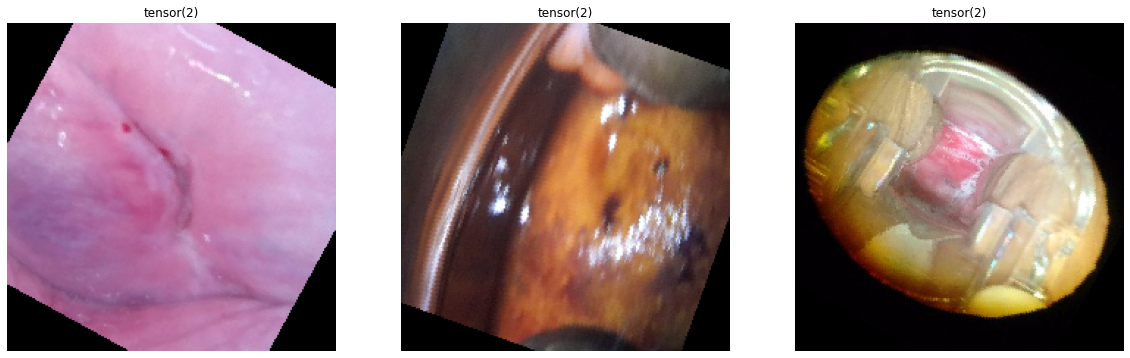

In [0]:
Im.show_all(imgs1.cpu().permute(0, 2, 3, 1)[0:3, :, :, :] * 0.5 + 0.5, lbls1[:3].cpu())

In [0]:
it2 = iter(cancer_testloader)
imgs2, lbls2 = next(it2)

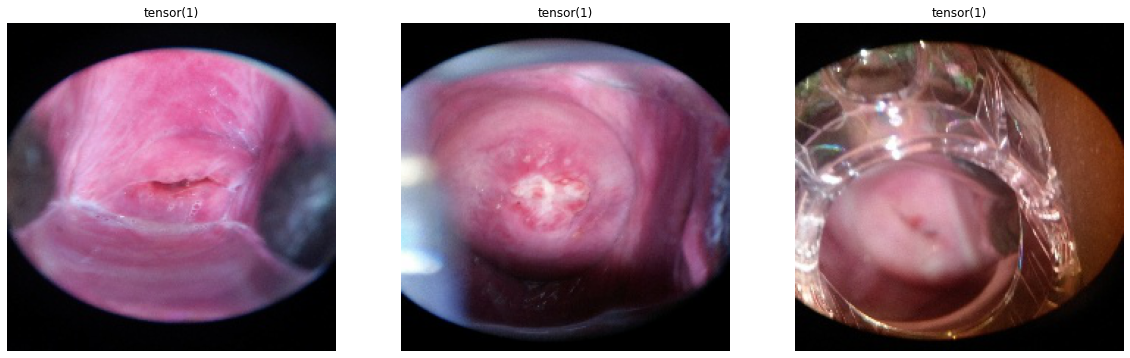

In [0]:
Im.show_all(imgs2.cpu().permute(0, 2, 3, 1)[0:3, :, :, :] * 0.5 + 0.5, lbls2[:3].cpu())

# **Models' Definitions**

LeNet Class Definition

In [0]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 7, 5)
        self.conv2 = torch.nn.Conv2d(7, 16, 5)

        self.fc1 = torch.nn.Linear(in_features=16 * 23 * 23, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc3 = torch.nn.Linear(in_features=84, out_features=NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.dropout(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.dropout(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.softmax(x, 1)

        return x

Accuracy Function Definition

In [0]:
def batch_accuracy(y, pred):
  # Calculates accuracy for a given batch of data
  
    true_positives = 0
    for p, lbl in zip(pred, y):
        pred_lbl = torch.argmax(p).item()
        if pred_lbl == lbl:
            true_positives += 1

    return true_positives / len(y)    

Training the model

In [0]:
class BackboneType(Enum):
    RESNET = 0
    RESNEXT = 1
    LENET = 2

In [0]:
def train(model, backbone, optimizer, scheduler, dataloader, num_epochs=10, loss=torch.nn.CrossEntropyLoss(), backboneType=BackboneType.RESNET):
    flag1 = backboneType is not BackboneType.LENET and backbone is not None
    flag2 = backboneType is BackboneType.LENET and backbone is None
    assert flag1 or flag2, "Incompatible model and backbone!"

    i = 0
    convergence_lst = list()
    accuracy_lst = list()

    for epoch in range(num_epochs):
        for x, y in tqdm(dataloader):
            optimizer.zero_grad()
            y = y.long().cuda() 

            if flag1: # Model is fully connected
                x = backbone.features(x)
                x = F.max_pool2d(x, 4)
                x = x.view(x.shape[0], -1)
                y_pred = model(x)
            elif flag2: # Model is whole LeNet
                y_pred = model(x)

            # Average batch loss and accuracy
            l = loss(y_pred, y)
            ac = batch_accuracy(y, y_pred)

            if i % 5 == 0:
                accuracy_lst.append(ac)
                convergence_lst.append(l)     

            l.backward()
            scheduler.step()

            # Free memory from cuda device
            del x
            del y

            i += 1
            print("epoch = " + str(epoch + 1) + " , loss = " + str(l.item()) + " , accuracy = " + str(ac))

    return convergence_lst, accuracy_lst

Resnet

In [0]:
resnet = pretrainedmodels.__dict__['resnet50'](num_classes=1000, pretrained='imagenet')
resnet.train()
resnet.cuda()

In [0]:
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
    
resnext = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')
resnext.train()
resnext.cuda()

In [0]:
fully_connected1 = torch.nn.Sequential(
torch.nn.ReLU(),
torch.nn.Dropout(),
torch.nn.Linear(2048, 512),
torch.nn.ReLU(),
torch.nn.Dropout(),

torch.nn.Linear(512, 128),
torch.nn.ReLU(),
torch.nn.Dropout(),

torch.nn.Linear(128, 32),
torch.nn.ReLU(),
torch.nn.Dropout(),

torch.nn.Linear(32, NUM_CLASSES),
torch.nn.Softmax(dim=1)).cuda()

In [0]:
radam1 = mylib1.RAdam(fully_connected1.parameters())
radam1.zero_grad()
sched1 = CosineAnnealingLR(radam1, len(cancer_trainloader) * BATCH_SIZE)

In [0]:
fully_connected2 = torch.nn.Sequential(
torch.nn.ReLU(),
torch.nn.Dropout(),
torch.nn.Linear(2048, 512),
torch.nn.ReLU(),
torch.nn.Dropout(),

torch.nn.Linear(512, 128),
torch.nn.ReLU(),
torch.nn.Dropout(),

torch.nn.Linear(128, 32),
torch.nn.ReLU(),
torch.nn.Dropout(),

torch.nn.Linear(32, NUM_CLASSES)).cuda()

In [0]:
radam2 = mylib1.RAdam(fully_connected2.parameters())
radam2.zero_grad()
sched2 = CosineAnnealingLR(radam2, len(cancer_trainloader) * BATCH_SIZE)

LeNet

In [0]:
lenet = LeNet()
lenet.cuda()

In [0]:
radam3 = mylib1.RAdam(lenet.parameters())
radam3.zero_grad()
sched3 = CosineAnnealingLR(radam3, len(cancer_trainloader) * BATCH_SIZE)

In [0]:
cl1, al1 = train(fully_connected1, resnet, radam1, sched1, cancer_trainloader, backboneType=BackboneType.RESNET, num_epochs=1)

In [0]:
cl2, al2 = train(fully_connected2, resnext, radam2, sched2, cancer_trainloader, backboneType=BackboneType.RESNEXT)

In [0]:
cl3, al3 = train(lenet, None, radam3, sched3, cancer_trainloader, backboneType=BackboneType.LENET, num_epochs=1)

Predict Function Definition

In [0]:
def predict(model, backbone, dataloader, backboneType, loss=torch.nn.CrossEntropyLoss()):
    flag1 = backboneType is not BackboneType.LENET and backbone is not None
    flag2 = backboneType is BackboneType.LENET and backbone is None
    assert flag1 or flag2, "Incompatible model and backbone!"

    preds = list() # For CSV file

    for data in dataloader:
        x, y = data
        y = y.long().cuda()

        if flag1: # Model is fully connected
            x = backbone.features(x)
            x = F.max_pool2d(x, 4)
            x = x.view(x.shape[0], -1)
            y_pred = model(x)
        elif flag2: # Model is whole LeNet
            y_pred = model(x)
        
        l = loss(y_pred, y)
        preds.append(y)
        ac = batch_accuracy(y, y_pred)
        accuracy_lst.append(ac)

        # Free memory from cuda device
        del x
        del y
      
    return (sum(accuracy_lst) / len(dataloader)), preds

In [0]:
ac1, preds1 = predict(fully_connected1, resnet, cancer_testloader, BackboneType.RESNET)

In [2]:
print("Test accuracy: ", ac1)

Test accuracy:  0.6811630218687873


In [0]:
ac2, preds2 = predict(fully_connected2, resnext, cancer_testloader, BackboneType.RESNEXT)

In [3]:
print("Test accuracy: ", ac2)

Test accuracy:  0.592196819085487


In [0]:
ac3, preds3 = predict(lenet, None, cancer_testloader, BackboneType.LENET)

In [1]:
print("Test accuracy: ", ac3)

Test accuracy:  0.84296819085487


In [0]:
def save_to_csv(model, dataloader, model_name):
    model = model.cpu()
    model = model.eval()
    index = 0

    with open('./kaggle/'+ model_name + '_result.csv', mode='w', newline='') as test_file:
        test_writer = csv.writer(test_file, quoting=csv.QUOTE_MINIMAL)
        test_writer.writerow(['image_name', 'Type_1', 'Type_2', 'Type_3'])
        
        for x, y in dataloader:
            x = x.permute(0, 3, 1, 2).float()
            x = x.cuda()
            y = y.cuda()
            y_pred = model(x)
            in_numpy = y_pred.cpu().detach().numpy()

            for result in in_numpy:
                test_writer.writerow([str(index) + '.jpg', result[0], result[1], result[2]])
                index += 1
                if index == 512:
                    index = 10000

**Predictions**

In [0]:
resnet_preds = pd.read_csv('/content/ResNet50_Preds.csv')

In [0]:
resnext_preds = pd.read_csv('/content/ResNext50_Preds.csv')

In [0]:
lenet_preds = pd.read_csv('/content/LeNet_Preds.csv')

In [24]:
lenet_preds.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.130287,0.595951,0.273762
1,1.jpg,0.077087,0.639261,0.283653
2,2.jpg,0.047076,0.804176,0.148749
3,3.jpg,0.048178,0.697264,0.254559
4,4.jpg,0.079874,0.555257,0.364869


In [25]:
resnet_preds.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.100853,0.555906,0.343241
1,1.jpg,0.061211,0.528151,0.410638
2,2.jpg,0.044884,0.501927,0.453188
3,3.jpg,0.131789,0.634300,0.233911
4,4.jpg,0.143988,0.636305,0.219707


In [26]:
resnext_preds.head()

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.011972,0.427242,0.560786
1,1.jpg,0.213997,0.583672,0.202332
2,2.jpg,0.119027,0.665902,0.215071
3,3.jpg,0.018087,0.442113,0.539801
4,4.jpg,0.112542,0.596209,0.291249


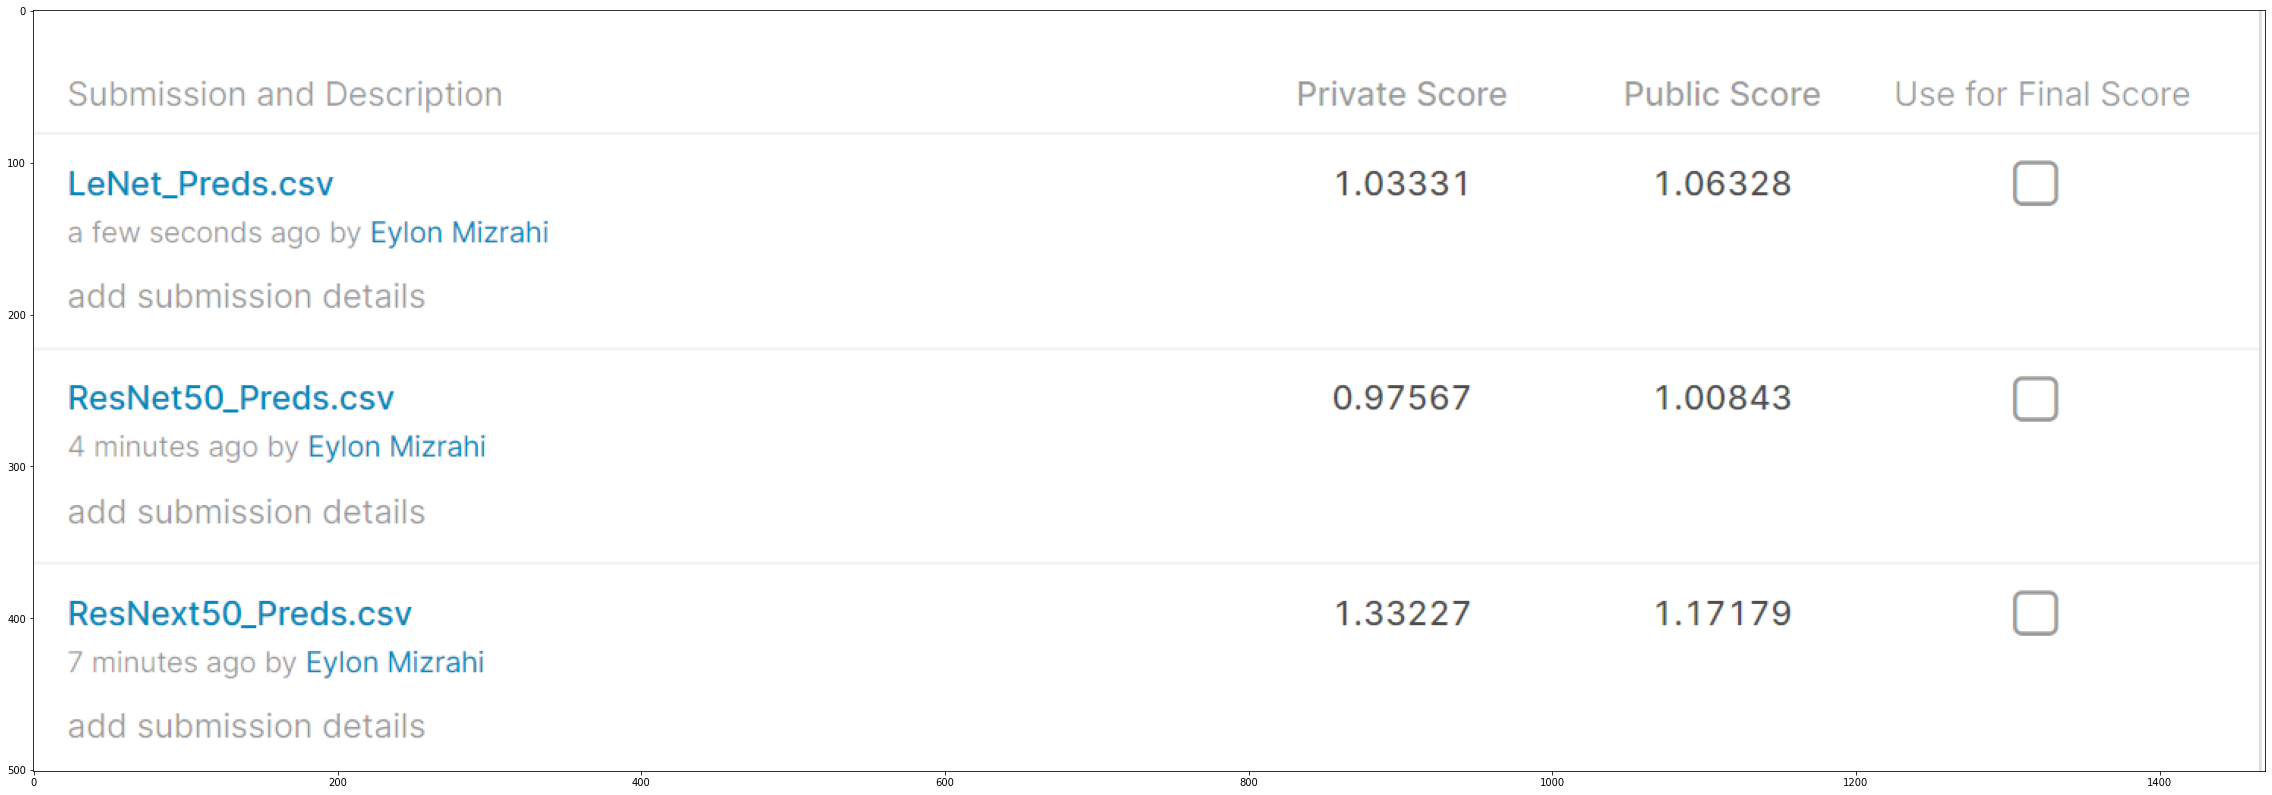

In [33]:
sub = plt.imread("/content/submission.jpg")
plt.figure(figsize=(40, 40))
plt.imshow(sub)

Functions to clear memory

In [0]:
def clear_ram(fc, backbone):
    del fc # Free fully connected model
    del backbone # Free backbone model
    gc.collect() # Free memory in cpu
    torch.cuda.empty_cache() # Free memory in gpu

In [0]:
def free_ds(ds, dl):
    del ds
    del dl

In [0]:
# free_ds(cancer_trainset, cancer_trainloader)

In [0]:
# free_ds(cancer_testset, cancer_testloader)

In [0]:
# clear_ram(None, None)

In [0]:
# clear_ram(fully_connected1, resnet)

In [0]:
# clear_ram(fully_connected2, resnext)

In [0]:
# clear_ram(lenet, None)